In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/banfakenews/LabeledAuthentic-7K.csv
/kaggle/input/banfakenews/Authentic-48K.csv
/kaggle/input/banfakenews/Fake-1K.csv
/kaggle/input/banfakenews/LabeledFake-1K.csv


In [ ]:
!pip install bnlp_toolkit

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')


import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
from bnlp import BasicTokenizer
from collections import defaultdict
from collections import  Counter
from bnlp import BengaliCorpus as b_corpus

In [ ]:
import time
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import train_test_split


from transformers import BertModel, BertTokenizer, BertForSequenceClassification

In [3]:
real = pd.read_csv("../input/banfakenews/Authentic-48K.csv")
fake = pd.read_csv("../input/banfakenews/Fake-1K.csv")

In [4]:
real.head()

,articleID,domain,date,category,headline,content,label
0,1,jagonews24.com,2018-09-19 17:48:18,Education,"হট্টগোল করায় বাকৃবিতে দুইজন বরখাস্ত, ৬ জনকে শোকজ",গত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে ...,1
1,2,jagonews24.com,2018-09-19 17:48:19,National,মালয়েশিয়ায় কর্মী পাঠানোর ব্যবস্থা নেয়ার সুপারিশ,বাংলাদেশের বৃহৎ শ্রমবাজার মালয়েশিয়ায় আবার শ্রম...,1
2,3,jagonews24.com,2018-09-19 17:48:20,National,প্রেমের প্রস্তাবে রাজি না হওয়ায় স্কুলছাত্রীকে ...,নরসিংদীর মনোহরদীতে প্রেমের প্রস্তাবে রাজি না হ...,1
3,4,jagonews24.com,2018-09-19 17:48:21,Crime,মেডিয়েশনই মামলাজট নিরসনের পথ : বিচারপতি আহমেদ ...,সুপ্রিম কোর্টের হাইকোর্ট বিভাগের বিচারপতি আহমে...,1
4,5,jagonews24.com,2018-09-19 17:48:21,National,টকশোতে বক্তব্য দিতে গিয়ে জাপা নেতার মৃত্যু,মাদারীপুর সদরের উপজেলার লেকেরপাড়ে একটি বেসরকার...,1


In [5]:
df = real._append(fake)

In [13]:
df.head()

,articleID,domain,date,category,headline,content,label
0,1,jagonews24.com,2018-09-19 17:48:18,Education,"হট্টগোল করায় বাকৃবিতে দুইজন বরখাস্ত, ৬ জনকে শোকজ",গত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে ...,1
1,2,jagonews24.com,2018-09-19 17:48:19,National,মালয়েশিয়ায় কর্মী পাঠানোর ব্যবস্থা নেয়ার সুপারিশ,বাংলাদেশের বৃহৎ শ্রমবাজার মালয়েশিয়ায় আবার শ্রম...,1
2,3,jagonews24.com,2018-09-19 17:48:20,National,প্রেমের প্রস্তাবে রাজি না হওয়ায় স্কুলছাত্রীকে ...,নরসিংদীর মনোহরদীতে প্রেমের প্রস্তাবে রাজি না হ...,1
3,4,jagonews24.com,2018-09-19 17:48:21,Crime,মেডিয়েশনই মামলাজট নিরসনের পথ : বিচারপতি আহমেদ ...,সুপ্রিম কোর্টের হাইকোর্ট বিভাগের বিচারপতি আহমে...,1
4,5,jagonews24.com,2018-09-19 17:48:21,National,টকশোতে বক্তব্য দিতে গিয়ে জাপা নেতার মৃত্যু,মাদারীপুর সদরের উপজেলার লেকেরপাড়ে একটি বেসরকার...,1


<Axes: xlabel='label'>

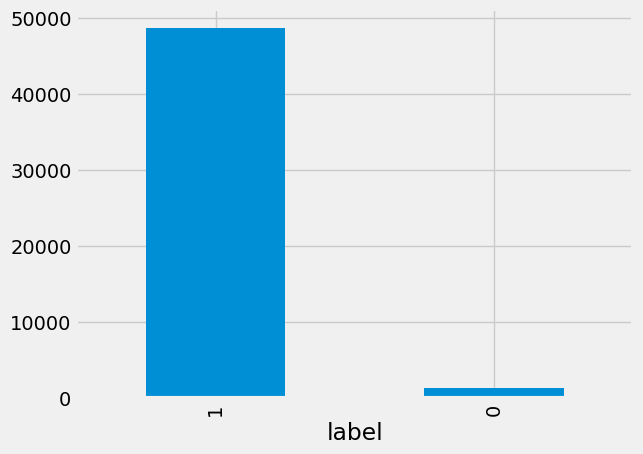

In [10]:
df.label.value_counts().plot(kind='bar')

In [20]:
tokenizer = BasicTokenizer()

print(tokenizer.tokenize(df.content.values[1]))

['বাংলাদেশের', 'বৃহৎ', 'শ্রমবাজার', 'মালয়েশিয়ায়', 'আবার', 'শ্রমিক', 'পাঠানোর', 'প্রয়োজনীয়', 'সব', 'ধরনের', 'ব্যবস্থা', 'নেয়ার', 'সুপারিশ', 'করেছে', 'সংসদীয়', 'কমিটি', '।', '২৫', 'সেপ্টেম্বর', 'প্রবাসী', 'কল্যাণ', 'ও', 'বৈদেশিক', 'কর্মসংস্থান', 'মন্ত্রণালয়ের', 'মন্ত্রীর', 'নেতৃত্বে', 'মালয়েশিয়ায়', 'জয়েন্ট', 'ওয়ার্কিং', 'গ্রুপের', 'একটি', 'সভা', 'হবে', '।', 'সভায়', 'শ্রমবাজারে', 'কর্মী', 'পাঠানোর', 'পরিবর্তিত', 'প্রক্রিয়া', 'চূড়ান্তকরণ', 'এবং', 'মালয়েশিয়ার', 'মানবসম্পদ', 'মন্ত্রণালয়সহ', 'অন্যান্য', 'সংশ্লিষ্ট', 'মন্ত্রণালয়ের', 'সঙ্গে', 'নিবিড়', 'যোগাযোগ', 'অব্যাহত', 'রাখার', 'সুপারিশ', 'করবে', 'কমিটি', '।', 'বুধবার', 'সংসদ', 'ভবনে', 'অনুষ্ঠিত', 'প্রবাসী', 'কল্যাণ', 'ও', 'বৈদেশিক', 'কর্মসংস্থান', 'মন্ত্রণালয়', 'সম্পর্কিত', 'স্থায়ী', 'কমিটির', '২৫তম', 'বৈঠকে', 'এ', 'সুপারিশ', 'করা', 'হয়', '।', 'কমিটির', 'সভাপতি', 'নূরুল', 'মজিদ', 'মাহমুদ', 'হুমায়ুনের', 'সভাপতিত্বে', 'বৈঠকে', 'উপস্থিত', 'ছিলেন', 'কমিটির', 'সদস্য', 'মো.', 'শাহাব', 'উদ্দিন', ',', 'মো.', 'ইসরাফিল', 'আলম', ',', 'মাহমুদ', 'উস', 

In [21]:
def create_corpus(docs):
    corpus=[]

    for doc in docs:
        tokens = tokenizer.tokenize(doc)
        corpus.extend(tokens)

    return corpus

In [27]:
real_corpus = create_corpus(real.headline.values[:1000])

print('Tokens in first 1000 rows of real news data(headline) is {0}'.format(len(real_corpus)))

Tokens in first 1000 rows of real news data(headline) is 7441


In [36]:
def show_stop_words(corpus, length=20):
    freq = defaultdict(int)

    for word in corpus:
        if word in b_corpus.stopwords:
            freq[word]+=1
    top=sorted(freq.items(), key=lambda x:x[1],reverse=True)[:length]
    x,y=zip(*top)
    print(x)
    print(y)

In [37]:
show_stop_words(real_corpus)

('না', 'ও', 'শুরু', 'হবে', 'করে', 'নিয়ে', 'জন্য', 'থেকে', 'দুই', 'নতুন', 'সঙ্গে', 'কোটি', 'করা', 'করতে', 'হচ্ছে', 'দিতে', 'পর', 'প্রথম', 'কাজ', 'হাজার')
(57, 34, 23, 23, 23, 22, 21, 21, 19, 17, 17, 16, 16, 14, 14, 11, 11, 11, 11, 11)


In [105]:
class NewsDataSet(Dataset):
    def __init__(self, data, max_length=100):
        super().__init__()
        self.data = data
    
        self.config = {
                "max_length": max_length,
                "padding": 'max_length',
                "return_tensors": "pt",
                "truncation": True,
                "add_special_tokens": True
            }
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['headline']+ "[SEP]" + value['content'],value['label']

In [54]:
df = real[:9000]
df = df._append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

10299

In [69]:
df.head()

,articleID,domain,date,category,headline,content,label
0,1150,earki.com,"১৬:২৪, জানুয়ারি ২২, ২০১৯",Miscellaneous,আহমেদইমতিয়াজবুলবুলেরশৈশবকৈশোরেরদুরন্তপনারকয়েকট...,‘কারগান’প্রশ্নেরউত্তরেসবসময়ইশোনাযায়গানেরশিল্পী...,0
1,1835,kalerkantho.com,2018-09-20 02:13:47,Politics,মতপ্রকাশপারছে,জাতীয়পার্টিরচেয়ারম্যানহুসেইনমুহম্মদএরশাদজাতিবধ...,1
2,846,bd-pratidin.com,2018-09-19 20:18:27,National,অাদালতেহাজিরহওয়ারশারীরিকসুস্থতাখালেদাজিয়ার,খালেদাজিয়ারআইনজীবীঅ্যাডেভােকেটমাসুদঅাহমেদতালুক...,1
3,10417,dhakatimes24.com,2018-09-23 12:36:34,Entertainment,মহেশের‘প্রেমিকা’রিয়া,বলিউডেরতাজাখবর২৬বছরবয়সীঅভিনেত্রীরিয়াচক্রবর্তীর...,1
4,3579,prothomalo.com,2018-09-20 17:50:46,National,বাসেরমোটরসাইকেলেরসংঘর্ষেতরুণনিহত,নড়াইলেবাসেরমোটরসাইকেলেরসংঘর্ষেআকাশশেখ১৮নামেরএক...,1


In [66]:
def clean_text(text):
    tokens = tokenizer.tokenize(text)
    stopwords = b_corpus.stopwords
    return "".join([word for word in tokens if (word not in b_corpus.punctuations) and (word not in (stopwords))])

In [68]:
df['headline'] = df.headline.apply(clean_text)
df['content'] = df.content.apply(clean_text)

In [70]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=41, stratify=df['label'])

In [106]:
training_data = NewsDataSet(train_df)
train_dl = DataLoader(training_data, batch_size=16, shuffle=True)


test_data = NewsDataSet(test_df)
test_dl = DataLoader(test_data, batch_size=16, shuffle=True)


In [75]:
class BanglaNewsBert(nn.Module):

    def __init__(self, bert):
        super().__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.layer1 = nn.Linear(in_features=768, out_features=128)

        # dense layer 2 (Output layer)
        self.layer2 = nn.Linear(in_features=128, out_features=2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.layer1(outputs[1])
        x = self.relu(x)
        # output layer
        x = self.layer2(self.dropout(x))
        
        return x


In [76]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BanglaNewsBert(bert)
model.to(device)

BanglaNewsBert(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [79]:
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [80]:
def train(model, dataloader, optimizer, criterion, config):
    model.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model.zero_grad()

        encoded_inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        
        input_ids = encoded_inputs['input_ids'].to(device)
        token_type_ids = encoded_inputs['token_type_ids'].to(device)
        attention_mask = encoded_inputs['attention_mask'].to(device)
        labels = labels.to(device)

        
        logs = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [89]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model.eval()  # prep model for evaluation
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            text, labels = batch
            encoded_inputs = tokenizer.batch_encode_plus(
                text, **config
            )
            input_ids = encoded_inputs['input_ids'].to(device)
            token_type_ids = encoded_inputs['token_type_ids'].to(device)
            attention_mask = encoded_inputs['attention_mask'].to(device)
            labels = labels.to(device)

            
            output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

            loss_p = criterion(output, labels)
            
            # update running validation loss
            valid_loss += loss_p.item() * input_ids.size(0)
            
            # calculate accuracy
            proba = torch.exp(output)
            top_p, top_class = proba.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            

            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [102]:
epochs = 10
MAX_LEN = 100
tokenizer_config = {
    "max_length": MAX_LEN,
    "padding": 'max_length',
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}


In [107]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.inf

best_loss = np.inf

start = time.time()
for epoch in tqdm(range(epochs)):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    end = time.time()

    # Train Model
    train_loss += train(model, train_dl, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model, test_dl, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dl.dataset)
    valid_loss = valid_loss / len(test_dl.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "banglanews_bert.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - start
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10


  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

	Train loss:0.311909.. 	Valid Loss:0.255769.. 	Accuracy: 92.0388
Epoch: 2/10


  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

	Train loss:0.235609.. 	Valid Loss:0.261748.. 	Accuracy: 92.1845
Epoch: 3/10


  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

	Train loss:0.171411.. 	Valid Loss:0.253987.. 	Accuracy: 92.5728
Epoch: 4/10


  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

	Train loss:0.161118.. 	Valid Loss:0.259277.. 	Accuracy: 92.9612
Epoch: 5/10


  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

	Train loss:0.149517.. 	Valid Loss:0.261104.. 	Accuracy: 92.9612
Epoch: 6/10


  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

	Train loss:0.151671.. 	Valid Loss:0.260915.. 	Accuracy: 92.9126
Epoch: 7/10


  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

	Train loss:0.149669.. 	Valid Loss:0.260978.. 	Accuracy: 93.0097
Epoch: 8/10


  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

	Train loss:0.146063.. 	Valid Loss:0.260871.. 	Accuracy: 93.0097
Epoch: 9/10


  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

	Train loss:0.151649.. 	Valid Loss:0.260868.. 	Accuracy: 93.0097
Epoch: 10/10


  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

	Train loss:0.147833.. 	Valid Loss:0.260863.. 	Accuracy: 93.0097
Training completed in 40m 4s


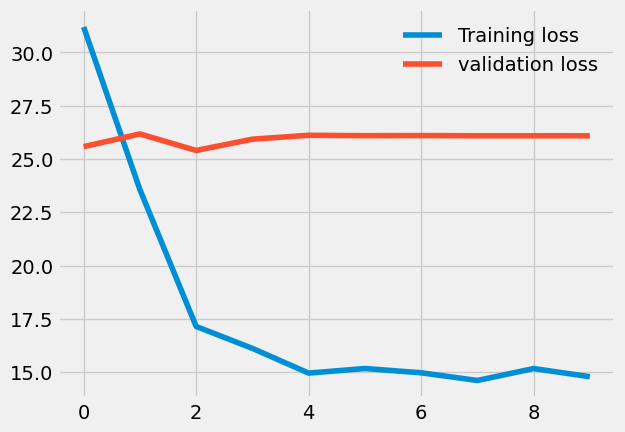

In [109]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="Validation loss")

plt.legend(frameon=False)

In [110]:
model.load_state_dict(torch.load("/kaggle/working/banglanews_bert.pth", map_location = device))

<All keys matched successfully>

In [112]:
y_pred = []
y_labels = []

for batch in tqdm(test_dl):
    text, labels = batch
    
    encoded_inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    
    input_ids = encoded_inputs['input_ids'].to(device)
    token_type_ids = encoded_inputs['token_type_ids'].to(device)
    attention_mask = encoded_inputs['attention_mask'].to(device)
    labels = labels.to(device)

    
    output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    y_pred.extend(preds)
    y_labels.extend(labels.cpu().numpy())

  0%|          | 0/129 [00:00<?, ?it/s]

In [114]:
from sklearn.metrics import classification_report

print(classification_report(y_labels, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.57      0.66       260
           1       0.94      0.98      0.96      1800

    accuracy                           0.93      2060
   macro avg       0.86      0.77      0.81      2060
weighted avg       0.92      0.93      0.92      2060

